Project by Alícia Gouveia and Sofia Rodrigues - Forecasting Forest Fires 

Import Dataset

In [1]:
import pandas as pd

df = pd.read_excel('Registos_Incendios_SGIF_2011_2020.xlsx', sheet_name = 'SGIF_2011_2020')
df.head()

,Codigo_SGIF,Codigo_ANEPC,Ano,Mes,Dia,Hora,AreaPov_ha,AreaMato_ha,AreaAgric_ha,AreaTotal_ha,...,ISI,DC,DMC,FFMC,BUI,CodCausa,TipoCausa,GrupoCausa,DescricaoCausa,FonteAlerta
0,DM2111,368,2011,1,1,17,0.0,0.010,0.00000,0.01000,...,0.291930,4.092373,0.653638,54.525424,0.934234,145.0,Negligente,Uso do fogo - Fogueiras,Fogueiras - Outras,Populares
1,BL4112,1236,2011,1,9,22,0.0,0.000,0.00200,0.00200,...,0.013831,1.835452,0.367371,32.001278,0.489703,610.0,Desconhecida,Indeterminadas,Indeterminadas - Prova material,Populares
2,DM3111,820,2011,1,15,17,0.0,0.000,0.00001,0.00001,...,1.171990,9.658571,1.573768,74.889775,2.236498,124.0,Negligente,Queimas amontoados de sobrantes florestais ou ...,Queima de amontoados - Borralheiras,Populares
3,BL2111,1977,2011,1,18,22,0.0,0.001,0.00000,0.00100,...,0.248910,12.477199,0.762519,51.102608,1.322920,124.0,Negligente,Queimas amontoados de sobrantes florestais ou ...,Queima de amontoados - Borralheiras,Populares
4,DM2113,7930,2011,1,19,17,0.0,0.005,0.00000,0.00500,...,0.008092,3.968661,0.508191,32.290416,0.769912,NaN,NaN,NaN,NaN,Populares


Relating burned area with meteorological indices:

Data Preparation

In [2]:
# Convert 'AreaTotal_ha' to binary (1 if fire, 0 if no fire)
df['Fire'] = df['AreaTotal_ha'].apply(lambda x: 1 if x > 0 else 0)

# Select relevant features
features = ['DSR', 'FWI', 'ISI', 'DC', 'DMC', 'FFMC', 'BUI']
target = 'Fire'

# Sample the data (e.g., 10% of the dataset)
df_sample = df.sample(frac=0.1, random_state=42)

X_sample = df_sample[features]
y_sample = df_sample[target]

# Handle missing values
X_sample = X_sample.fillna(X_sample.mean())

Exploratory Data Analysis (EDA)

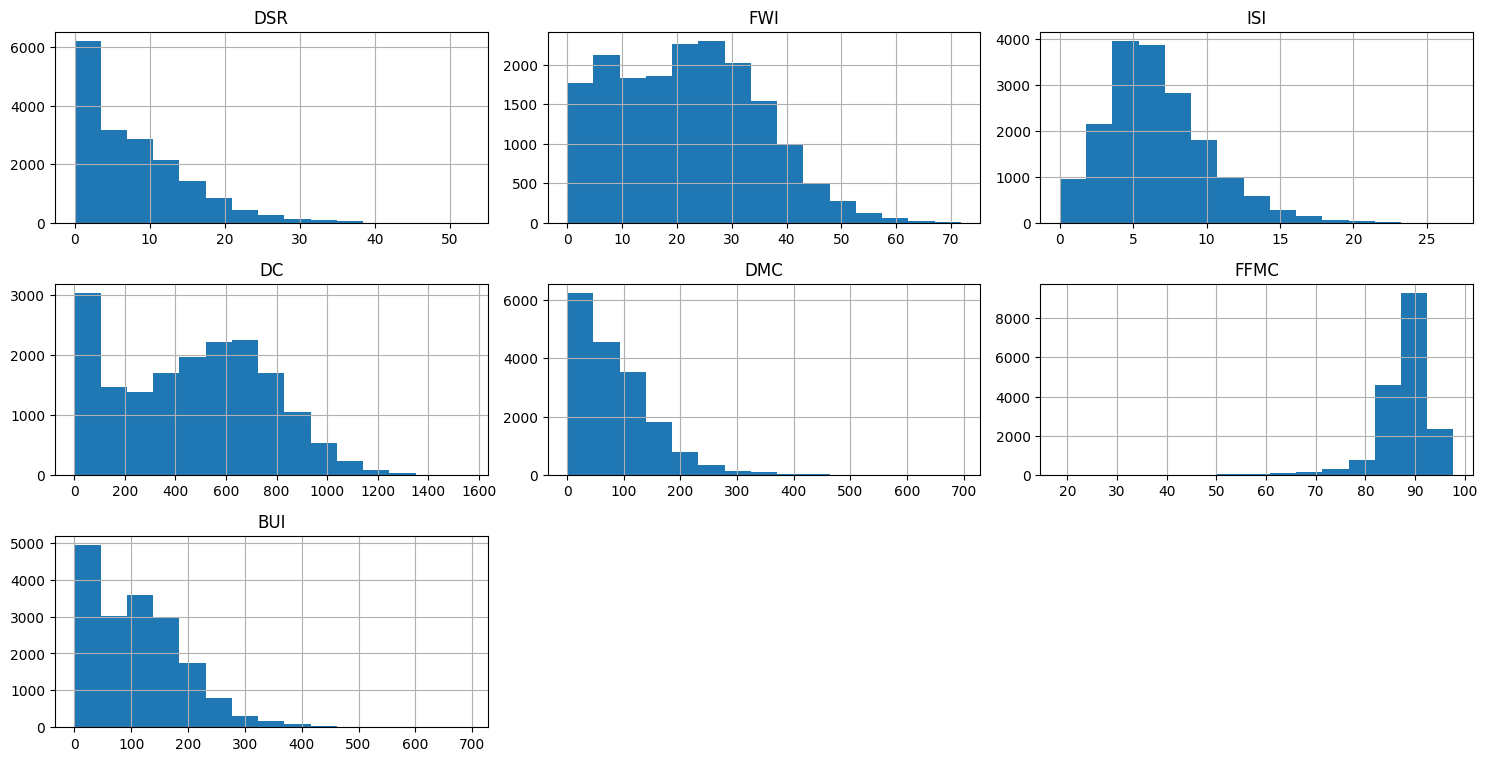

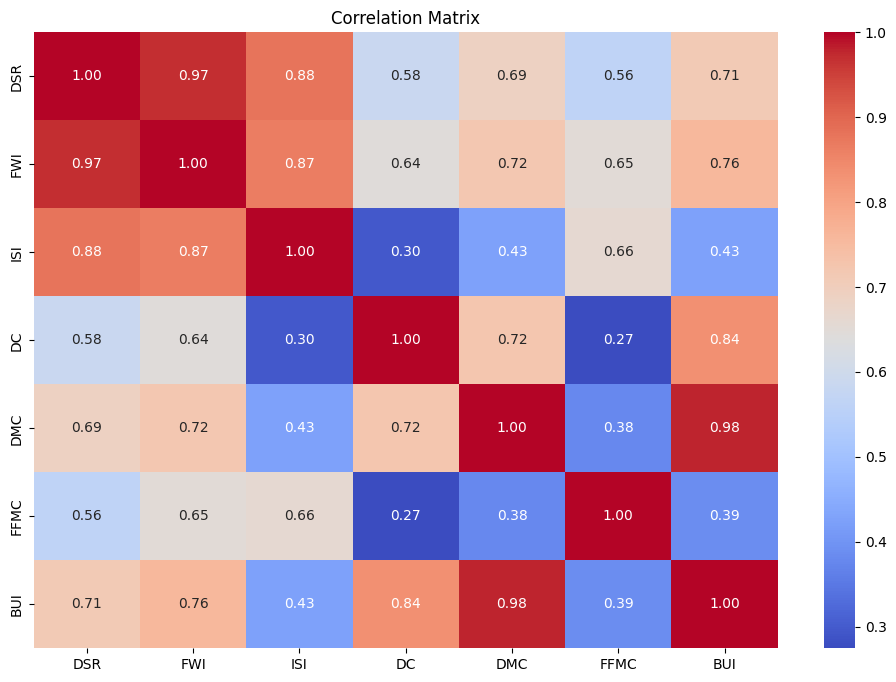

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot distributions of numerical features
numerical_features = features
df_sample[numerical_features].hist(bins=15, figsize=(15, 10), layout=(4, 3))
plt.tight_layout()
plt.show()

# Correlation matrix
corr_matrix = df_sample[numerical_features].corr()
# Plot heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


PCA Analysis

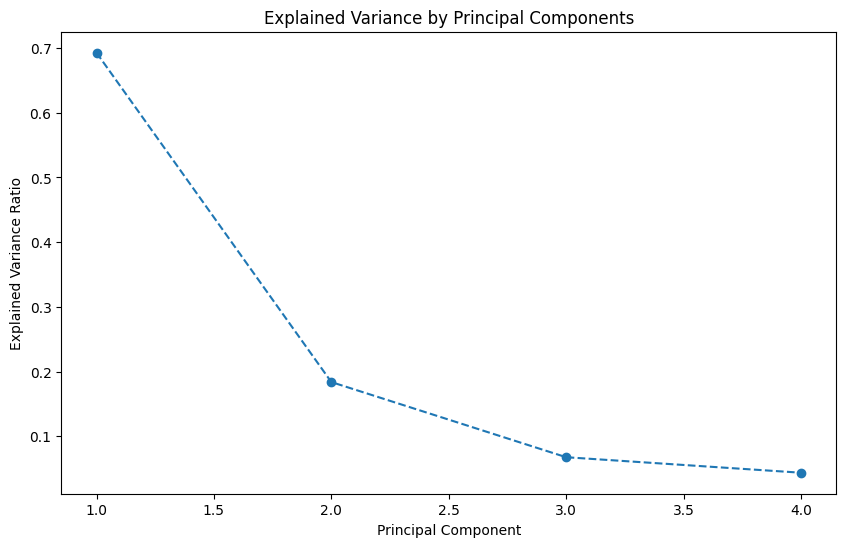

In [4]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Address class imbalance using SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_sample, y_sample)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Perform PCA for dimensionality reduction
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Visualize the explained variance ratio of PCA components
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

Model Training - Random Forest (Logistic Regression)

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Initialize and train Logistic Regression model
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_pca, y_train)
y_pred_log = log_reg.predict(X_test_pca)

# Initialize and train Random Forest model with parallel processing
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_clf.fit(X_train_pca, y_train)
y_pred_rf = rf_clf.predict(X_test_pca)

Model Evaluation - Random Forest (Logistic Regression)

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Evaluate Logistic Regression model
acc_log = accuracy_score(y_test, y_pred_log)
prec_log = precision_score(y_test, y_pred_log)
rec_log = recall_score(y_test, y_pred_log)
f1_log = f1_score(y_test, y_pred_log)
roc_auc_log = roc_auc_score(y_test, y_pred_log)

print(f'Logistic Regression Accuracy: {acc_log}')
print(f'Logistic Regression Precision: {prec_log}')
print(f'Logistic Regression Recall: {rec_log}')
print(f'Logistic Regression F1 Score: {f1_log}')
print(f'Logistic Regression ROC AUC: {roc_auc_log}')

# Evaluate Random Forest model
acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf)
rec_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_rf)

print(f'Random Forest Accuracy: {acc_rf}')
print(f'Random Forest Precision: {prec_rf}')
print(f'Random Forest Recall: {rec_rf}')
print(f'Random Forest F1 Score: {f1_rf}')
print(f'Random Forest ROC AUC: {roc_auc_rf}')


Logistic Regression Accuracy: 0.5649836820886927
Logistic Regression Precision: 0.5741352720863626
Logistic Regression Recall: 0.5006724303554275
Logistic Regression F1 Score: 0.5348932676518884
Logistic Regression ROC AUC: 0.5649343352621181
Random Forest Accuracy: 0.9249376079861777
Random Forest Precision: 0.9472194135490394
Random Forest Recall: 0.8999039385206532
Random Forest F1 Score: 0.9229556650246306
Random Forest ROC AUC: 0.9249183993389762


Save model and other features needed for the app

In [7]:
import joblib

# Save the model, scaler, and PCA
joblib.dump(rf_clf, 'fire_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(pca, 'pca.pkl')

['pca.pkl']

App - Fire or No Fire

In [8]:
# CODE IN APP.PY

import streamlit as st
import joblib
import numpy as np

# Load the model, scaler, and PCA
model = joblib.load('fire_model.pkl')
scaler = joblib.load('scaler.pkl')
pca = joblib.load('pca.pkl')

st.title("Forest Fire Prediction App")

# Input fields for the indices
DSR = st.number_input('DSR (0-64)', min_value=0.00, max_value=64.00, value=0.00)
FWI = st.number_input('FWI (0-64)', min_value=0.00, max_value=64.00, value=0.00)
ISI = st.number_input('ISI (0-30)', min_value=0.00, max_value=30.00, value=0.00)
DC = st.number_input('DC (0-1043)', min_value=0.00, max_value=1043.00, value=0.00)
DMC = st.number_input('DMC (0-467)', min_value=0.00, max_value=467.00, value=0.00)
FFMC = st.number_input('FFMC (0-99)', min_value=0.00, max_value=99.00, value=0.00)
BUI = st.number_input('BUI (0-325)', min_value=0.00, max_value=457.00, value=0.00)

# Prediction
if st.button('Predict'):
    features = np.array([[DSR, FWI, ISI, DC, DMC, FFMC, BUI]])
    features_scaled = scaler.transform(features)
    features_pca = pca.transform(features_scaled)
    prediction = model.predict(features_pca)
    if prediction == 1:
        st.write("Prediction: Fire")
    else:
        st.write("Prediction: No Fire")

2024-07-05 16:49:33.154 
  command:

    streamlit run C:\Users\sofia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\ipykernel_launcher.py [ARGUMENTS]
2024-07-05 16:49:33.159 Session state does not function when running a script without `streamlit run`


Run the app

In [9]:
!streamlit run app.py

^C
